In [165]:
import numpy as np, matplotlib.pyplot as plt, glob, os, pandas as pd, copy, regex as re,\
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, imageio,\
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm, json, joblib as jl, itertools
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm
import shapely.ops, shapely.geometry as geom
from skimage.measure import label
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, wilcoxon
from statsmodels.stats.multitest import multipletests

### Specify data files to display

In [3]:
fnameP = 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.filtered2.npy'
fnameA = 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.filtered2.npy'
fnames = [fnameP, fnameA]

In [4]:
fnames = [[x for x in glob.glob('\\\\?\\Z:\\behavior\\*\\wavelet\\{}'.format(fn)) if 'RIG' not in x] for fn in fnames]
len(fnames[0]), len(fnames[1])

(21, 21)

In [5]:
fnameP = 'Y:/wavelet/rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd/'
fnameP+= 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameP = '\\\\?\\' + fnameP.replace('/', '\\')

fnameA = 'Y:/wavelet/rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd/'
fnameA+= 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameA = '\\\\?\\' + fnameA.replace('/', '\\')

fnamesShared = [fnameP, fnameA]

fnamesWatershed = [x.replace('.npy', '.smoothed.watershed.npy') for x in fnamesShared]
fnamesWatershed = [(x if os.path.exists(x) else None) for x in fnamesWatershed]
arrWatershed = [np.load(x) for x in fnamesWatershed]

In [6]:
# Find recording information
fnamesRecordingInfo = [[os.path.join(os.path.dirname(os.path.dirname(x)), 
    'recording.json') for x in fn] for fn in fnames]

def loadJSON(x):
    if os.path.exists(x):
        with open(x, 'r') as f:
            return json.load(f)
    else:
        return None
    
recordingInfo = [[loadJSON(x) for x in fn] for fn in fnamesRecordingInfo]

# Exclude recordings that are incomplete or invalid
useRecording = [[('stages' in ri and (isinstance(ri['stages']['radii'], list) or ri['stages']['radii'] > 0) and \
    ri['web_complete'] and ri['tracking_successful']) for ri in _recordingInfo] \
        for _recordingInfo in recordingInfo]

fnames = [[x for x, b in zip(fnames[k], useRecording[k]) if b] for k in range(len(fnames))]
recordingInfo = [[x for x, b in zip(recordingInfo[k], useRecording[k]) if b] for k in range(len(fnames))]

len(fnames[0]), len(fnames[1])

(21, 21)

In [ ]:
# Fill in missing stage information, if necessary
for z in tqdm(range(len(recordingInfo)), leave=False):
    for i in tqdm(range(len(recordingInfo[z])), leave=False):
        s = recordingInfo[z][i]
        # Find position/orientation
        s['fname'] = glob.glob(os.path.abspath(os.path.join(fnames[z][i], 
            '../../croprot/*dlc_position_orientation.npy')))[0]

        # Does this recording.json file specify stage ranges, or starting points?
        for st in s['stages']:
            if s['stages'][st] == []:
                s['stages'][st] = []
            elif not isinstance(s['stages'][st][0], list):
                s['stages'][st] = [s['stages'][st], ]
        
        s['stagesOrg'] = copy.deepcopy(s['stages'])
        
        # Convert to indices used in analysis
        arrIdx = np.load(s['fname'].replace('_position_orientation.npy',
                                            '_abs_filt_interp_mvmt_noborder.idx.npy'))
        for st in s['stages']:
            for k in range(len(s['stages'][st])):
                for m in range(2):
                    s['stages'][st][k][m] = np.argmin(np.abs(np.argwhere(arrIdx).T[0] - s['stages'][st][k][m]))

In [ ]:
Hs = [[], []]

for z in tqdm(range(len(fnames)), leave=False):
    for i in tqdm(range(len(fnames[z])), leave=False):
        _H = {}
        for stage in recordingInfo[z][i]['stages']:
            # Load embedded data
            arr = np.load(fnames[z][i].replace('.filtered2.npy', '.clusters.npy')).copy()[:,0]
            # Determine what frame ranges belong to this stage
            idxSS = np.full(arr.shape[0], False, dtype=np.bool)
            for i0, i1 in recordingInfo[z][i]['stages'][stage]:
                idxSS[i0:i1] = True
            # Keep only embedding data in the current stage
            arr = arr[idxSS]
            arr = arr[~np.isnan(arr)]
            # Compute histogram
            _H[stage] = arr.copy().astype(int)
        Hs[z].append(_H)

In [9]:
def toNumber(x):
    try:
        return int(x)
    except:
        return -1
    
def loadLabels(fnameLabels):
    txtClusterLabels = ''
    with open(fnameLabels, 'r') as f:
        txtClusterLabels = f.read()
    clusterLabels = {}
    curLabel = ''
    for line in txtClusterLabels.split('\n'):
        if ':' in line:
            curLabel = line[:line.find(':')]
        elif len(line.strip()) > 0:
            clusterLabels[curLabel] = [toNumber(x) for x in line.split(',') if toNumber(x) >= 0]
    return clusterLabels

In [10]:
fnameClusterLabelsA = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd\\cluster_names.txt'
fnameClusterLabelsP = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\cluster_names.txt'
fnamesLabels = (fnameClusterLabelsP, fnameClusterLabelsA)

clusterLabels = (loadLabels(fnamesLabels[0]), loadLabels(fnamesLabels[1]))
clusterLabelsUnique = list(set(list(clusterLabels[0].keys()) + list(clusterLabels[1].keys())))
clusterLabelsUnique = [x for x in clusterLabelsUnique if x not in ['noisy',]]

### Compute leg sweep statistics

In [157]:
ANTERIOR = 1
POSTERIOR= 0

In [158]:
# Count individual events if they are at least 500 ms apart and not contiguous 
# (don't count long stretches multiple times)
def countEvents(a, cls, minFrameGap = 50):
    numEvents = 0
    lastEventI = -minFrameGap
    eventDuration = 0
    for i in range(a.shape[0]):
        if a[i] in cls and (i-lastEventI) >= minFrameGap and eventDuration < 12:
            eventDuration += 1
            if eventDuration == 12: # Reached min-duration threshold of 240 ms
                lastEventI = i
                numEvents += 1
        elif a[i] not in cls:
            eventDuration = 0
    return numEvents

In [159]:
clusterIdsLegSweeps = np.hstack([clusterLabels[ANTERIOR][x] for x in [
    'left-leg', 'right-leg', 'one-leg-after-other']]).astype(int)

In [160]:
stageDistances = {}
stageDurations = {}
PIXEL_TO_CM = 10 / 1000
MINTRAVEL_1SEC = 5
MAXTRAVEL_1SEC = 500
for stage in tqdm(recordingInfo[1][0]['stagesOrg'], leave=False):
    for recInfo in tqdm(recordingInfo[1], leave=False):
        xy = np.load(recInfo['fname'])[:,0:2]
        idx = np.full(xy.shape[0], False, dtype=np.bool)
        for t0, t1 in recInfo['stagesOrg'][stage]:
            idx[t0:t1] = True
        a = np.linalg.norm(np.diff(xy[idx][::50,:], axis=0), axis=1)
        a = np.nansum(a[(a > MINTRAVEL_1SEC)&(a < MAXTRAVEL_1SEC)])
        if stage not in stageDistances:
            stageDistances[stage] = []
            stageDurations[stage] = []
        stageDistances[stage].append(a * PIXEL_TO_CM)
        stageDurations[stage].append(np.sum(idx) * 0.02)

C:\Users\acorver\.conda\envs\spider\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
C:\Users\acorver\.conda\envs\spider\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


In [161]:
dataEvents = []

for stage in Hs[ANTERIOR][0].keys():
    numEvents = np.array([countEvents(x[stage], clusterIdsLegSweeps, 50) for x in Hs[ANTERIOR]])
    distances = np.array(stageDistances[stage])
    durations = np.array(stageDurations[stage])
    eventsPerCM = numEvents[distances > 0] / distances[distances > 0]
    eventsPerS  = numEvents[distances > 0] / durations[distances > 0]
    
    for ev in eventsPerCM:
        dataEvents.append((stage, ev))
    
    print('Leg Sweep Occurrence for Stage {}: {:.3f} +- {:.3f} (events)'.format(
        stage, np.nanmean(numEvents[distances > 0]), np.nanstd(numEvents[distances > 0])))
    
    print('Leg Sweep Occurrence for Stage {}: {:.3f} +- {:.3f} (events/cm)'.format(
        stage, np.nanmean(eventsPerCM), np.nanstd(eventsPerCM)))
    
    print('Leg Sweep Occurrence for Stage {}: {:.3f} +- {:.3f} (events/s) '.format(
        stage, np.nanmean(eventsPerS), np.nanstd(eventsPerS)))
    
tblEvents = pd.DataFrame(dataEvents, columns=['stage', 'events_per_cm'])

Leg Sweep Occurrence for Stage protoweb: 435.095 +- 225.677 (events)
Leg Sweep Occurrence for Stage protoweb: 1.219 +- 0.303 (events/cm)
Leg Sweep Occurrence for Stage protoweb: 0.049 +- 0.015 (events/s) 
Leg Sweep Occurrence for Stage radii: 645.333 +- 381.600 (events)
Leg Sweep Occurrence for Stage radii: 1.292 +- 0.401 (events/cm)
Leg Sweep Occurrence for Stage radii: 0.125 +- 0.069 (events/s) 
Leg Sweep Occurrence for Stage spiral_aux: 119.400 +- 44.624 (events)
Leg Sweep Occurrence for Stage spiral_aux: 1.722 +- 0.456 (events/cm)
Leg Sweep Occurrence for Stage spiral_aux: 0.332 +- 0.075 (events/s) 
Leg Sweep Occurrence for Stage spiral_cap: 925.238 +- 448.445 (events)
Leg Sweep Occurrence for Stage spiral_cap: 3.065 +- 0.533 (events/cm)
Leg Sweep Occurrence for Stage spiral_cap: 0.204 +- 0.051 (events/s) 
Leg Sweep Occurrence for Stage stabilimentum: 34.667 +- 19.431 (events)
Leg Sweep Occurrence for Stage stabilimentum: 8.748 +- 2.935 (events/cm)
Leg Sweep Occurrence for Stage st

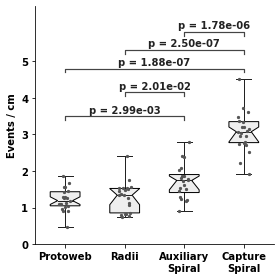

In [180]:
d = tblEvents[(tblEvents.stage != 'stabilimentum')&(tblEvents.events_per_cm != 0)]

pairs = list(itertools.combinations(STAGES, 2))
pvals = [mannwhitneyu(x=d.events_per_cm[d.stage==p[0]], 
                      y=d.events_per_cm[d.stage==p[1]], alternative='two-sided').pvalue for p in pairs]
pvals = multipletests(pvals, alpha=0.05, method='bonferroni')[1]
pairsSignificant = [(p, pv) for p, pv in zip(pairs, pvals) if pv < 0.05]
pairsSignificant

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

for istage, stage in enumerate(STAGES):
    y = d.events_per_cm[d.stage==stage]
    x0 = np.ones(y.size) * istage + (-0.5 + np.random.random(size=y.size)) * .2
    ax.scatter(x0, y, color='#555555', s=5, zorder=20)
    bp = ax.boxplot(y, positions=(istage,), whis=(0,100), widths=0.5,
               notch=True, bootstrap=10000, zorder=10, patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')

ax.set_xticklabels([{
    'protoweb': 'Protoweb',
    'radii': 'Radii',
    'spiral_aux': 'Auxiliary\nSpiral',
    'spiral_cap': 'Capture\nSpiral'
}[x] for x in STAGES])
    
[ax.spines[x].set_visible(False) for x in ['top', 'right']]

ax.set_ylabel('Events / cm')

ax.set_ylim(0, 6.5)
ax.set_yticks([0,1,2,3,4,5])

lvls = {
    ('protoweb', 'spiral_aux'): 3.5,
    ('protoweb', 'spiral_cap'): 4.8,
    ('radii', 'spiral_aux'): 4.15,
    ('radii', 'spiral_cap'): 5.3,
    ('spiral_aux', 'spiral_cap'): 5.8,
}
for p, pv in pairsSignificant:
    i0 = STAGES.index(p[0])
    i1 = STAGES.index(p[1])
    lvl = lvls[p]
    ax.plot([i0, i0, i1, i1], [lvl-0.1, lvl, lvl, lvl-0.1], 
            color='#444444', linewidth=1.2)
    ax.text((i0 + i1) * 0.5, lvl * 1.01, 
        'p = {:.2e}'.format(pv), ha='center', va='bottom', color='#222222')
    
fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_legsweeps.pdf')

## Pause duration statistics

In [15]:
# Count individual events if they are at least 500 ms apart and not contiguous 
# (don't count long stretches multiple times)
def countEventDurations(a, cls, minFrameGap = 50, minDuration = 12):
    eventDurations = []
    lastEventI = -minFrameGap
    eventDuration = 0
    for i in range(a.shape[0]):
        if a[i] in cls:
            eventDuration += 1
            if eventDuration == minDuration: # Reached min-duration threshold of 240 ms
                eventDurations.append(eventDuration)
        elif a[i] not in cls:
            if eventDuration >= minDuration:
                eventDurations[-1] = eventDuration
            eventDuration = 0
    if eventDuration >= minDuration:
        eventDurations[-1] = eventDuration    
    return eventDurations

In [16]:
def loadIdxAVI(fname):
    # Get index
    fnameIdx = glob.glob(os.path.abspath(os.path.join(os.path.dirname(fname), 
        '../croprot/*_dlc_abs_filt_interp_mvmt_noborder.idx.npy')))[0]
    idx = np.load(fnameIdx)
    # Load AVI mapping
    suffix = 'avimapping2.npy'
    fnameAVImapping = glob.glob(os.path.abspath(os.path.join(os.path.dirname(
        fname), '../raw/*_{}'.format(suffix))))[0]
    aviMapping = np.load(fnameAVImapping)
    # Already exists?
    lensAVI = []
    aviIDs = np.sort([int(re.search('-([0-9]*)\\.avi', x).group(1)) for x in glob.glob(
        fnameAVImapping.replace('_{}'.format(suffix), '*.avi'))])
    i0 = aviIDs[aviMapping[:,1].min()]
    i1 = aviIDs[aviMapping[:,1].max()]
    print('Using movie chunks {} -> {}'.format(i0, i1))
    for aviID in range(i0, i1+1):
        fnameAVI = fnameAVImapping.replace('_{}'.format(suffix), '-{:04}.avi').format(aviID)
        if not os.path.exists(fnameAVI):
            fnameAVI = fnameAVImapping.replace('_{}'.format(suffix), '-{}.avi').format(aviID)
        if not os.path.exists(fnameAVI):
            lensAVI.append(lensAVI[-1])
        else:
            r = imageio.get_reader(fnameAVI)
            lensAVI.append(len(r))
            r.close()
            del r

    # Map recording indices to AVI indices
    tmp = pd.DataFrame(aviMapping, columns=['idx', 'avi', 'a', 'diff', 'lens'])
    tmp = tmp.groupby('avi').count()
    chunkIDused = tmp.index[tmp.idx >= 4]

    # Attribute each index to a chunk... Start with NaNs, then fill in
    chunkIDs = np.full(idx.size, np.nan, dtype=np.float64)
    for chid in np.unique(aviMapping[:,1]):
        if chid in chunkIDused:
            s0 = np.min(aviMapping[aviMapping[:,1]==chid,0])
            s1 = np.max(aviMapping[aviMapping[:,1]==chid,0])
            chunkIDs[min(chunkIDs.size-1, s0)] = chid
            chunkIDs[min(chunkIDs.size-1, s1)] = chid
    while np.any(np.isnan(chunkIDs)):
        chunkIDs = pd.DataFrame(chunkIDs).fillna(
            method='ffill', limit=100).fillna(method='bfill', limit=100).values[:,0]
    chunkIDs = chunkIDs.astype(int)
    # Whenever there's an avi chunk skip, add the left-out chunk sizes
    idxAVI = np.zeros(chunkIDs.size, dtype=int)
    for i in tqdm(range(1, chunkIDs.size), leave=False):
        idxAVI[i] = idxAVI[i-1] + 1 + np.sum([lensAVI[x] for x in range(chunkIDs[i-1], chunkIDs[i]-1)])
    _idxAVI = np.full(np.max(idxAVI)+1, False, dtype=np.bool)
    _idxAVI[idxAVI] = True
    idxAVI = _idxAVI
    return idxAVI

In [17]:
# Load AVI indices (computed in )
idxsAVI = jl.Parallel(n_jobs=22)(jl.delayed(loadIdxAVI)(fn) for fn in fnames[0])

In [ ]:
dataPauses = []
for stage in tqdm(Hs[ANTERIOR][0].keys(), leave=False):
    for recID in tqdm(range(len(Hs[ANTERIOR])), leave=False):
        # Load the index of stationary frames
        _isStationary = np.logical_not(np.load(recordingInfo[1][recID]['fname'].replace(
            '_dlc_position_orientation.npy', '_dlc_abs_filt_interp_mvmt.idx.npy')))
        # Load the index of embedded frames
        _isEmbedded = np.logical_not(np.load(recordingInfo[1][recID]['fname'].replace(
            '_dlc_position_orientation.npy', '_dlc_abs_filt_interp_mvmt_noborder.idx.npy')))
        # is canonical?
        _iscanonical = max([len(recordingInfo[1][recID]['stagesOrg'][st]) for \
            st in recordingInfo[1][recID]['stagesOrg']]) == 1
        # Build index
        for stagerep, (t0, t1) in enumerate(recordingInfo[1][recID]['stagesOrg'][stage]):
            idx = np.full(_isEmbedded.shape[0], False, dtype=np.bool)
            idx[t0:t1] = True
            isStationary = _isStationary[idx].copy()
            isEmbedded = _isEmbedded[idx].copy()
            # Determine what frames are stationary according to embedding
            isStationaryInEmbedding = np.isin(Hs[ANTERIOR][recID][stage], 
                clusterLabels[ANTERIOR]['stationary']) | \
                np.isin(Hs[ANTERIOR][recID][stage], clusterLabels[POSTERIOR]['stationary'])
            # Incorporate these embedding-stationary frames into the larger is-stationary index
            s = min(np.sum(~isEmbedded), isStationaryInEmbedding.size)
            isStationary[np.argwhere(~isEmbedded)[:s,0]] = isStationaryInEmbedding[:s]
            # Span brief interruptions (<=12 frames)
            isStationary = ndimage.binary_erosion(ndimage.binary_dilation(
                isStationary, iterations=12), iterations=12)
            # Now extrapolate to AVI
            _idxStageAVI = np.argwhere(idxsAVI[recID])[idx, 0]
            isStationaryWithAVI = np.full(_idxStageAVI.max()+1, True, dtype=np.bool)
            isStationaryWithAVI[_idxStageAVI] = isStationary
            isStationaryWithAVI = isStationaryWithAVI[_idxStageAVI.min():]
            # Now subset to 10% - 90% of distance traveled to exclude pauses at boundary
            # Measure cumulative distance traveled...
            fnameXY = glob.glob(os.path.abspath(os.path.join(os.path.dirname(fnames[0][recID]), 
                '../croprot/*_dlc_position_orientation.npy')))[0]
            arrXY = np.load(fnameXY)[idx, 0:2]
            
            vels = pd.DataFrame(np.linalg.norm(arrXY - pd.DataFrame(
                arrXY).shift(-50).values, axis=1)).fillna(method='ffill').fillna(method='bfill').values[:,0]
            vels[vels < 5] = 0

            _s0 = np.argwhere(np.cumsum(vels) >= 0.10 * np.max(np.cumsum(vels)))[0,0]
            _s1 = np.argwhere(np.cumsum(vels) <= 0.90 * np.max(np.cumsum(vels)))[-1,0]

            s0 = (_idxStageAVI - _idxStageAVI.min())[_s0]
            s1 = (_idxStageAVI - _idxStageAVI.min())[_s1]
            
            pc0AVI  = _idxStageAVI[0]
            pc10AVI = _idxStageAVI[_s0]
            pc90AVI = _idxStageAVI[_s1]
            pc100AVI= _idxStageAVI[-1]
            
            # Extract relevant info
            stageRepStart = np.min(_idxStageAVI)
            stageRepEnd = np.max(_idxStageAVI)
            stageRepDuration = t1 - t0

            for _type in ['mid', 'pre', 'post']:
                s0s1 = np.full(isStationaryWithAVI.size, False, dtype=np.bool)
                if _type == 'mid':
                    s0s1[s0:s1] = True
                elif _type == 'pre':
                    s0s1[:s0] = True
                else:
                    s0s1[s1:] = True
                    
                # Count durations
                eventDurations = np.array(countEventDurations(isStationaryWithAVI[s0s1], [True,], 12))
                # Store
                for ed in eventDurations:
                    dataPauses.append((stage, recID, stagerep, ed, stageRepStart, 
                                       stageRepEnd, stageRepDuration, _iscanonical, 
                                       _type, pc0AVI, pc10AVI, pc90AVI, pc100AVI))

In [135]:
dataPauses = pd.DataFrame(dataPauses, columns=[
    'stage', 'recid', 'stagerep', 'pause', 'stage_start', 'stage_end', 
    'stage_duration', 'canonical', 'window', 'pc0avi', 'pc10avi', 'pc90avi', 'pc100avi'])
dataPauses.shape

(32758, 13)

In [136]:
# Add recording name information
dataPauses.loc[:,'recname'] = [
    re.search('/behavior/([^/]*)/?', fnames[0][i].replace(
        '\\', '/')).group(1) for i in dataPauses.recid]

# Export for use elsewhere
dataPauses.to_pickle('C:/Users/acorver/Desktop/paper-figures/table_pausestats.pickle')

In [80]:
STAGES = ['protoweb', 'radii', 'spiral_aux', 'spiral_cap', 'stabilimentum'] # dataPauses.stage.unique()
STAGES

['protoweb', 'radii', 'spiral_aux', 'spiral_cap', 'stabilimentum']

In [81]:
# Source: http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.nanmean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

In [83]:
dataPausesOrg = dataPauses.copy()

In [112]:
# Now relabel pre-radii as post-protoweb, etc.
dataPauses = dataPausesOrg[(dataPausesOrg.window != 'mid')&(dataPausesOrg.stagerep == 0)].copy()

In [113]:
_idx = dataPauses.index[(dataPauses.stage=='radii')&(dataPauses.window=='pre')]
dataPauses.loc[_idx, 'stage'] = 'protoweb'
dataPauses.loc[_idx, 'window'] = 'post'
dataPauses = dataPauses[(dataPauses.stage!='protoweb')|(dataPauses.window=='pre')]

_idx = dataPauses.index[(dataPauses.stage=='spiral_aux')&(dataPauses.window=='pre')]
dataPauses.loc[_idx, 'stage'] = 'radii'
dataPauses.loc[_idx, 'window'] = 'post'

_idx = dataPauses.index[(dataPauses.stage=='spiral_cap')&(dataPauses.window=='pre')]
dataPauses.loc[_idx, 'stage'] = 'spiral_aux'
dataPauses.loc[_idx, 'window'] = 'post'

_idx = dataPauses.index[(dataPauses.stage=='stabilimentum')&(dataPauses.window=='pre')]
dataPauses.loc[_idx, 'stage'] = 'spiral_cap'
dataPauses.loc[_idx, 'window'] = 'post'

In [114]:
includeMaxima = False

In [ ]:
for clip in [False,]: # [True, False]:
    fig, ax = plt.subplots(1, 6, figsize=(18, 3))

    STAGES = ['protoweb', 'radii', 'spiral_aux', 'spiral_cap']
    
    dataPauses2 = dataPauses.copy()
    if clip:
        dataPauses2.pause.clip(upper=50000, inplace=True)
    for istage, stage in enumerate(STAGES):
        for can in [True, False]:
            print(stage, can)
            hists = [np.histogram(np.log10(dataPauses2[(dataPauses2.stage==stage)&(
                dataPauses2.recid==recid)&(dataPauses2.stagerep==0)].pause.values * 0.02), range=(0, 3), bins=30) for \
                    recid in dataPauses2.recid[dataPauses2.canonical == can].unique()]
            bins = hists[0][1]
            bins = 0.5 * bins[1:] + 0.5 * bins[:-1]
            hists = np.array([x[0] for x in hists])
            ci = np.array([bootstrap(hists[:,i], 5000, np.nanmedian)(0.95) for i in range(hists.shape[1])])
            ciMinmax = np.array([(np.nanpercentile(hists[:,i], 0), 
                                  np.nanpercentile(hists[:,i], 50), 
                                  np.nanpercentile(hists[:,i], 100)) for i in range(hists.shape[1])])
            #ci = np.log10(1+ci)
            #ciMinmax = np.log10(1+ciMinmax)
            ax[istage].fill_between(bins, ci[:,0], ci[:,1], color='#888888' if can else '#ff8888', alpha=0.25)
            if includeMaxima:
                ax[istage].plot(bins, ciMinmax[:,0], color='#888888' if can else '#ff8888', linestyle='--')
                ax[istage].plot(bins, ciMinmax[:,2], color='#888888' if can else '#ff8888', linestyle='--')
            
            ax[istage].plot(bins, ciMinmax[:,1], color='#888888' if can else '#ff8888')
            
            #for i in range(hists.shape[0]):
            #    ax[istage].plot(bins, np.log10(1+hists[i, :]), color='#888888' if can else '#ff8888')

        if istage != 0:
            pass
            #ax[istage].spines["left"].set_visible(False)
            #ax[istage].get_yaxis().set_visible(False)
        else:
            ax[istage].set_ylabel('Pause Bout Occurrences')
        ax[istage].spines["top"].set_visible(False)
        ax[istage].spines["right"].set_visible(False)
        ax[istage].spines["bottom"].set_visible(False)
        if istage == 1:
            ax[istage].set_xlabel('{}Pause Bout Duration (seconds)'.format(
                ''.join([' ' for i in range(50)])))
        
        ax[istage].set_ylim(0, [20, 16, 1, 30][istage])
        
        ax[istage].set_xlim(0, 3)
        ax[istage].set_xticks([0, 1, 2, 3])
        ax[istage].set_xticklabels(['1', '10', '100', '1000'])
        ax[istage].set_title(['Protoweb', 'Radii', 'Auxiliary Spiral', 'Capture Spiral'][istage])
    
    # Legend
    L1 = mlines.Line2D([0, 1], [0, 0], color='#ff8888', linestyle='--', 
                       label='Minimum and Maximum Pause\nBout Occurrence (Non-Canonical)\n')
    L2 = mlines.Line2D([0, 1], [0, 0], color='#888888', linestyle='--', 
                       label='Minimum and MaximumPause\nBout Occurrence (Canonical)\n')
    L3 = mlines.Line2D([0, 1], [0, 0], color='#ff8888', linestyle='-', 
                       label='Median Pause Bout Occurrence (Non-Canonical)\n')
    L4 = mlines.Line2D([0, 1], [0, 0], color='#888888', linestyle='-', 
                       label='Median Pause Bout Occurrence (Canonical)\n')
    L5 = mpatches.Patch(color='#ff8888', alpha=0.25, label=
                        '95% Confidence Interval of Median\nPause Bout Occurrence (Non-Canonical)\n')
    L6 = mpatches.Patch(color='#888888', alpha=0.25, label=
                        '95% Confidence Interval of Median\nPause Bout Occurrence (Canonical)')
    ax[-1].legend(handles=([L1, L2] if includeMaxima else []) + [L3, L4, L5, L6], frameon=False)
    ax[-1].set_axis_off()
    ax[-2].set_axis_off()

    #fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_pause_duration_distribution_1{}_10-90.pdf'.format(
    #    '_clip' if clip else ''))

In [ ]:
for clip in [True, False]:
    fig, ax = plt.subplots(1, 6, figsize=(18, 3))

    STAGES = ['protoweb', 'radii', 'spiral_aux', 'spiral_cap']

    dataPauses2 = dataPauses.copy()
    dataPauses2.loc[:,'pause_rel'] = dataPauses2.pause / dataPauses2.stage_duration
    if clip:
        dataPauses2.pause_rel.clip(upper=0.1, inplace=True)
    
    for istage, stage in enumerate(STAGES):
        for can in [True, False]:
            hists = [np.histogram(np.log10(dataPauses2[(dataPauses2.stage==stage)&(
                dataPauses2.recid==recid)&(dataPauses2.stagerep==0)].pause_rel.values), range=(-5, -1), bins=40) for \
                    recid in dataPauses2.recid[dataPauses2.canonical == can].unique()]
            bins = hists[0][1]
            bins = 0.5 * bins[1:] + 0.5 * bins[:-1]
            hists = np.array([x[0] for x in hists])

            ci = np.array([bootstrap(hists[:,i], 1000, np.nanmedian)(0.95) for i in range(hists.shape[1])])
            ciMinmax = np.array([(np.nanpercentile(hists[:,i], 0), 
                                  np.nanpercentile(hists[:,i], 50), 
                                  np.nanpercentile(hists[:,i], 100)) for i in range(hists.shape[1])])
            #ci = np.log10(1+ci)
            #ciMinmax = np.log10(1+ciMinmax)
            ax[istage].fill_between(bins, ci[:,0], ci[:,1], color='#888888' if can else '#ff8888', alpha=0.25)
            if includeMaxima:
                ax[istage].plot(bins, ciMinmax[:,0], color='#888888' if can else '#ff8888', linestyle='--')
                ax[istage].plot(bins, ciMinmax[:,2], color='#888888' if can else '#ff8888', linestyle='--')

            ax[istage].plot(bins, ciMinmax[:,1], color='#888888' if can else '#ff8888')

            #for i in range(hists.shape[0]):
            #    ax[istage].plot(bins, np.log10(1+hists[i, :]), color='#888888' if can else '#ff8888')

        if istage != 0:
            pass
            #ax[istage].spines["left"].set_visible(False)
            #ax[istage].get_yaxis().set_visible(False)
        else:
            ax[istage].set_ylabel('Pause Bout Occurrences')
        ax[istage].spines["top"].set_visible(False)
        ax[istage].spines["right"].set_visible(False)
        ax[istage].spines["bottom"].set_visible(False)
        if istage == 1:
            ax[istage].set_xlabel('{}Pause Bout Duration (% of Stage Duration)'.format(
                ''.join([' ' for i in range(50)])))

        ax[istage].set_ylim(0, [70, 70, 12, 100][istage])

        ax[istage].set_xticks([-5, -4, -3, -2, -1])
        ax[istage].set_xticklabels(['0.001%', '0.01%', '0.1%', '1%', '10%'], rotation=45)
        ax[istage].set_title(['Protoweb', 'Radii', 'Auxiliary Spiral', 'Capture Spiral'][istage])

    # Legend
    L1 = mlines.Line2D([0, 1], [0, 0], color='#ff8888', linestyle='--', 
                       label='Minimum and Maximum Pause\nBout Occurrence (Non-Canonical)\n')
    L2 = mlines.Line2D([0, 1], [0, 0], color='#888888', linestyle='--', 
                       label='Minimum and MaximumPause\nBout Occurrence (Canonical)\n')
    L3 = mlines.Line2D([0, 1], [0, 0], color='#ff8888', linestyle='-', 
                       label='Median Pause Bout Occurrence (Non-Canonical)\n')
    L4 = mlines.Line2D([0, 1], [0, 0], color='#888888', linestyle='-', 
                       label='Median Pause Bout Occurrence (Canonical)\n')
    L5 = mpatches.Patch(color='#ff8888', alpha=0.25, label=
                        '95% Confidence Interval of Median\nPause Bout Occurrence (Non-Canonical)\n')
    L6 = mpatches.Patch(color='#888888', alpha=0.25, label=
                        '95% Confidence Interval of Median\nPause Bout Occurrence (Canonical)')
    ax[-1].legend(handles=([L1, L2] if includeMaxima else []) + [L3, L4, L5, L6], frameon=False)
    ax[-1].set_axis_off()
    ax[-2].set_axis_off()

    fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_pause_duration_distribution_2{}.pdf'.format(
        '_clip' if clip else ''))

In [106]:
dataPausesTotal = dataPauses.loc[(dataPauses.stagerep==0)&(dataPauses.pause <= 50 * 60), [
    'stage', 'recid', 'canonical', 'pause']].groupby(['stage', 'recid', 'canonical']).sum().reset_index()

In [152]:
dataPauses.pause.max() / (3600 * 50)

8.168811111111111

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(8, 4))

for istage, stage in enumerate(STAGES):
    y0 = dataPausesTotal.pause[(dataPausesTotal.stage==stage)&(
        dataPausesTotal.canonical)] / (50 * 3600)
    bp = ax[istage].boxplot(y0, positions=[1,], 
        notch=True, bootstrap=1000, whis=(0,100), widths=(0.5,), patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
    x0 = np.ones(y0.size) * 1 + (np.random.random(size=y0.size) - 0.5) * 0.5
    ax[istage].scatter(x0, y0, s=5, color='#000000', zorder=50)
    
    y1 = dataPausesTotal.pause[(dataPausesTotal.stage==stage)&(
        ~dataPausesTotal.canonical)] / (50 * 3600)
    bp = ax[istage].boxplot(y1, positions=[2,], 
        notch=True, bootstrap=1000, whis=(0,100), widths=(0.5,), patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
    x1 = np.ones(y1.size) * 2 + (np.random.random(size=y1.size) - 0.5) * 0.5
    ax[istage].scatter(x1, y1, s=5, color='#000000', zorder=50)
    
    if istage == 0:
        ax[istage].set_ylabel('Total Pause\nDuration (Hours)')
    ax[istage].spines["top"].set_visible(False)
    ax[istage].spines["right"].set_visible(False)
    ax[istage].spines["bottom"].set_visible(False)
    ax[istage].set_xticklabels(['Canonical', 'Non-\nCanonical'], rotation=45)
    
    ax[istage].set_title(['Protoweb', 'Radii', 'Auxiliary Spiral', 'Capture Spiral'][istage])
    
    xticks = [1, 2]
    ymax = max(np.max(y0), np.max(y1))
    ax[istage].set_ylim(0, ymax * 1.2)
    
    # Permutation-test p-value
    tmp = dataPausesTotal[(dataPausesTotal.stage==stage)].copy().reset_index()
    diffs = []
    for i in tqdm(range(10001), leave=False):
        #diffs.append(np.nanmean(tmp.pause[tmp.canonical]) - np.nanmean(tmp.pause[~tmp.canonical]))
        diffs.append(np.nanmedian(tmp.pause[tmp.canonical]) - np.nanmedian(tmp.pause[~tmp.canonical]))
        tmp.canonical = np.random.permutation(tmp.canonical)

    d0 = diffs[0]
    d = diffs[1:]
    pval = np.mean(np.abs(d) >= abs(d0))
    
    #pval = mannwhitneyu(y0, y1, alternative='two-sided').pvalue
    
    ax[istage].plot([xticks[0], xticks[0], xticks[1], xticks[1]], 
        [ymax * 1.02, ymax * 1.04, ymax * 1.04, ymax * 1.02], lw=1.5, c='#222222')
    ax[istage].text((xticks[0]+xticks[1])*.5, ymax*1.08, 
        'p = {:.3f}'.format(pval), ha='center', va='bottom', color='#222222')
    
fig.suptitle('Permutation Test (bouts <= 1 minute)')
fig.tight_layout(rect=[0, 0, 1.0, 0.9])
#fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_pauses_canonical_vs_noncanonical.pdf')

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(8, 4))

for istage, stage in enumerate(STAGES):
    y0 = dataPausesTotal.pause[(dataPausesTotal.stage==stage)&(
        dataPausesTotal.canonical)] / (50 * 3600)
    bp = ax[istage].boxplot(y0, positions=[1,], 
        notch=True, bootstrap=1000, whis=(0,100), widths=(0.5,), patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
    x0 = np.ones(y0.size) * 1 + (np.random.random(size=y0.size) - 0.5) * 0.5
    ax[istage].scatter(x0, y0, s=5, color='#000000', zorder=50)
    
    y1 = dataPausesTotal.pause[(dataPausesTotal.stage==stage)&(
        ~dataPausesTotal.canonical)] / (50 * 3600)
    bp = ax[istage].boxplot(y1, positions=[2,], 
        notch=True, bootstrap=1000, whis=(0,100), widths=(0.5,), patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
    x1 = np.ones(y1.size) * 2 + (np.random.random(size=y1.size) - 0.5) * 0.5
    ax[istage].scatter(x1, y1, s=5, color='#000000', zorder=50)
    
    if istage == 0:
        ax[istage].set_ylabel('Total Pause\nDuration (Hours)')
    ax[istage].spines["top"].set_visible(False)
    ax[istage].spines["right"].set_visible(False)
    ax[istage].spines["bottom"].set_visible(False)
    ax[istage].set_xticklabels(['Canonical', 'Non-\nCanonical'], rotation=45)
    
    ax[istage].set_title(['Protoweb', 'Radii', 'Auxiliary Spiral', 'Capture Spiral'][istage])
    
    xticks = [1, 2]
    ymax = max(np.max(y0), np.max(y1))
    ax[istage].set_ylim(0, ymax * 1.2)
    
    # Permutation-test p-value
    tmp = dataPausesTotal[(dataPausesTotal.stage==stage)].copy().reset_index()
    diffs = []
    for i in tqdm(range(10001), leave=False):
        #diffs.append(np.nanmean(tmp.pause[tmp.canonical]) - np.nanmean(tmp.pause[~tmp.canonical]))
        diffs.append(np.nanmedian(tmp.pause[tmp.canonical]) - np.nanmedian(tmp.pause[~tmp.canonical]))
        tmp.canonical = np.random.permutation(tmp.canonical)

    d0 = diffs[0]
    d = diffs[1:]
    pval = np.mean(np.abs(d) >= abs(d0))
    
    #pval = mannwhitneyu(y0, y1, alternative='two-sided').pvalue
    
    ax[istage].plot([xticks[0], xticks[0], xticks[1], xticks[1]], 
                                [ymax * 1.02, ymax * 1.04, ymax * 1.04, ymax * 1.02], lw=1.5, c='#222222')
    ax[istage].text((xticks[0]+xticks[1])*.5, ymax*1.08, 
        'p = {:.3f}'.format(pval), ha='center', va='bottom', color='#222222')
    
fig.suptitle('Permutation Test (bouts <= 1 minute)')
fig.tight_layout(rect=[0, 0, 1.0, 0.9])
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_pauses_canonical_vs_noncanonical.pdf')

### Compute pauses statistics

In [16]:
# Stationary state is determined by:
#   - Stationary state detected by anterior
#   - Stationary state detected by posterior
#   - Frame being left out of embedding computation due to lack of movement
# These timepoint indices are first merged together, than the usual counting is done as above for leg sweeps.

In [19]:
dataPauses = []
dataPausesBetweenStages = []
for stage in Hs[ANTERIOR][0].keys():
    isStationaryAll = []
    for recID in range(len(Hs[ANTERIOR])):
        # Load the index of stationary frames
        _isStationary = np.logical_not(np.load(recordingInfo[1][recID]['fname'].replace(
            '_dlc_position_orientation.npy', '_dlc_abs_filt_interp_mvmt.idx.npy')))
        # Load the index of embedded frames
        _isEmbedded = np.logical_not(np.load(recordingInfo[1][recID]['fname'].replace(
            '_dlc_position_orientation.npy', '_dlc_abs_filt_interp_mvmt_noborder.idx.npy')))
        # Canonical?
        _iscanonical = max([len(recordingInfo[1][recID]['stagesOrg'][st]) for \
            st in recordingInfo[1][recID]['stagesOrg']]) == 1
        # Subset this index by what stage we're looking at
        for stagerep, (t0, t1) in enumerate(recordingInfo[1][recID]['stagesOrg'][stage]):
            idx = np.full(_isEmbedded.shape[0], False, dtype=np.bool)
            idx[t0:t1] = True
            isStationary = _isStationary[idx]
            isEmbedded = _isEmbedded[idx]
            # Determine what frames are stationary according to embedding
            isStationaryInEmbedding = np.isin(Hs[ANTERIOR][recID][stage], clusterLabels[ANTERIOR]['stationary']) | \
                np.isin(Hs[ANTERIOR][recID][stage], clusterLabels[POSTERIOR]['stationary'])
            # Incorporate these embedding-stationary frames into the larger is-stationary index
            s = min(np.sum(~isEmbedded), isStationaryInEmbedding.size)
            isStationary[np.argwhere(~isEmbedded)[:s,0]] = isStationaryInEmbedding[:s]
            # Set minimum pause duration
            isStationary2 = ndimage.binary_dilation(ndimage.binary_erosion(
                isStationary, iterations=75), iterations=75)
            # Now extrapolate to AVI
            _idxStageAVI = np.argwhere(idxsAVI[recID])[idx, 0]
            isStationaryWithAVI = np.full(_idxStageAVI.max()+1 if _idxStageAVI.size > 0 else 0, True, dtype=np.bool)
            if isStationaryWithAVI.size > 0:
                isStationaryWithAVI[_idxStageAVI] = isStationary
                isStationaryWithAVI = isStationaryWithAVI[_idxStageAVI.min():]
            # Now extrapolate to AVI
            isStationaryWithAVI2 = np.full(_idxStageAVI.max()+1 if _idxStageAVI.size > 0 else 0, True, dtype=np.bool)
            if isStationaryWithAVI2.size > 0:
                isStationaryWithAVI2[_idxStageAVI] = isStationary2
                isStationaryWithAVI2 = isStationaryWithAVI2[_idxStageAVI.min():]
            # Now subset to 10% - 90% of distance traveled to exclude pauses at boundary
            # Measure cumulative distance traveled...
            fnameXY = glob.glob(os.path.abspath(os.path.join(os.path.dirname(fnames[0][recID]), 
                '../croprot/*_dlc_position_orientation.npy')))[0]
            arrXY = np.load(fnameXY)[idx, 0:2]

            vels = pd.DataFrame(np.linalg.norm(arrXY - pd.DataFrame(
                arrXY).shift(-50).values, axis=1)).fillna(method='ffill').fillna(method='bfill').values[:,0]
            vels[vels < 5] = 0

            _s0 = np.argwhere(np.cumsum(vels) >= 0.10 * np.max(np.cumsum(vels)))[0,0]
            _s1 = np.argwhere(np.cumsum(vels) <= 0.90 * np.max(np.cumsum(vels)))[-1,0]

            s0 = (_idxStageAVI - _idxStageAVI.min())[_s0]
            s1 = (_idxStageAVI - _idxStageAVI.min())[_s1]
            
            # Store boundary data
            dataPausesBetweenStages.append( (stage, recID, stagerep, t0, t1, 'post', 
                                             isStationaryWithAVI[s1:], isStationaryWithAVI2[s1:], _iscanonical) )
            dataPausesBetweenStages.append( (stage, recID, stagerep, t0, t1, 'pre', 
                                             isStationaryWithAVI[:s0], isStationaryWithAVI2[:s0], _iscanonical) ) 
            
            # Store in overall list
            isStationaryAll.append((isStationaryWithAVI[s0:s1], isStationaryWithAVI2[s0:s1], recID, stagerep))
    
    isStationaryAllMergedreps = [np.hstack([np.zeros(0, dtype=np.bool)] + [y[0] for y in isStationaryAll if y[2] == recID]) for \
                                 recID in range(len(fnames[0]))]
    numEvents = np.array([countEvents(x, [True,], 50) for x in isStationaryAllMergedreps])
    distances = np.array(stageDistances[stage])
    durations = np.array(stageDurations[stage])
    eventsPerCM = numEvents[distances > 0] / distances[distances > 0]
    eventsPerS  = numEvents[distances > 0] / durations[distances > 0]
    #percentTime = 100 * np.array([np.sum(x[1]) * 0.02 for x in isStationaryAll]) / durations
    percentTime = 100 * np.array([np.nanmean(x[1]) for x in isStationaryAll])
    
    for pt, stagerep, recID in zip(percentTime, [x[3] for x in isStationaryAll], [x[2] for x in isStationaryAll]):
        dataPauses.append((stage, stagerep, pt, recID))
    
    print('Pause (>=1 s) Occurrence for Stage {}: {:.3f} +- {:.3f} (events)'.format(
        stage, np.nanmean(numEvents[distances > 0]), np.nanstd(numEvents[distances > 0])))
    
    print('Pause (>=1 s) Occurrence for Stage {}: {:.3f} +- {:.3f} (events/cm)'.format(
        stage, np.nanmean(eventsPerCM), np.nanstd(eventsPerCM)))
    
    print('Pause (>=1 s) Occurrence for Stage {}: {:.3f} +- {:.3f} (events/s) '.format(
        stage, np.nanmean(eventsPerS), np.nanstd(eventsPerS)))
    
    print('Percent Time Paused for Stage {}: {:.3f} +- {:.3f} (events/s) '.format(
        stage, np.nanmean(percentTime), np.nanstd(percentTime)))

Pause (>=1 s) Occurrence for Stage protoweb: 258.095 +- 183.460 (events)
Pause (>=1 s) Occurrence for Stage protoweb: 0.863 +- 0.582 (events/cm)
Pause (>=1 s) Occurrence for Stage protoweb: 0.034 +- 0.023 (events/s) 
Percent Time Paused for Stage protoweb: 84.761 +- 20.337 (events/s) 
Pause (>=1 s) Occurrence for Stage radii: 360.810 +- 280.459 (events)
Pause (>=1 s) Occurrence for Stage radii: 0.728 +- 0.420 (events/cm)
Pause (>=1 s) Occurrence for Stage radii: 0.055 +- 0.016 (events/s) 
Percent Time Paused for Stage radii: 61.917 +- 31.916 (events/s) 
Pause (>=1 s) Occurrence for Stage spiral_aux: 19.700 +- 11.637 (events)
Pause (>=1 s) Occurrence for Stage spiral_aux: 0.262 +- 0.137 (events/cm)
Pause (>=1 s) Occurrence for Stage spiral_aux: 0.051 +- 0.027 (events/s) 
Percent Time Paused for Stage spiral_aux: 0.551 +- 1.499 (events/s) 
Pause (>=1 s) Occurrence for Stage spiral_cap: 311.810 +- 159.060 (events)
Pause (>=1 s) Occurrence for Stage spiral_cap: 1.075 +- 0.438 (events/cm)
P

In [20]:
tblPauses = pd.DataFrame(dataPauses, columns=['stage', 'stagerep', 'pauses', 'recid'])

In [54]:
STAGES

['protoweb', 'radii', 'spiral_aux', 'spiral_cap']

In [1401]:
# For each stage gap, for every recording, gather the pairs and compute percentage paused
dataPausesWithGaps = []
for stageGap in STAGES:
    for recID in range(len(fnames[0])):
        for stagerep in range(4):
            try:
                xPre = [x for x in dataPausesBetweenStages if x[0]==stageGap and \
                        x[1] == recID and x[5]=='post' and x[2] == stagerep][0]
                xPost= [x for x in dataPausesBetweenStages if 
                        x[1] == recID and x[5]=='pre' and x[3] == xPre[4]][0]
                pausesGap = np.hstack((xPre[7], xPost[7]))
                pause = np.nansum(pausesGap) / (50 * 3600)
                iscanonical = xPre[8]
                #pause = 100 * np.nanmean(pausesGap)
                dataPausesWithGaps.append((stageGap, stagerep, pause, recID))
            except:
                pass
tblPausesWithGaps = pd.DataFrame(dataPausesWithGaps, columns=['stage', 'stagerep', 'pauses', 'recid', 'canonical'])

In [66]:
# For each stage gap, for every recording, gather the pairs and compute percentage paused
dataPausesWithGaps = []
for stageGap in [
        'protoweb-radii',
        'radii-spiral_aux',
        'spiral_aux-spiral_cap',
        'spiral_cap-stabilimentum',
        'spiral_cap-radii']:
    for recID in range(len(fnames[0])):
        for stagerep in range(4):
            try:
                xPre = [x for x in dataPausesBetweenStages if x[0]==stageGap.split('-')[0] and \
                        x[1] == recID and x[5]=='post' and x[2] == stagerep][0]
                xPost= [x for x in dataPausesBetweenStages if x[0]==stageGap.split('-')[1] and \
                        x[1] == recID and x[5]=='pre' and x[3] == xPre[4]][0]
                pausesGap = np.hstack((xPre[7], xPost[7]))
                
                #pause = np.nansum(pausesGap) / (50 * 3600)
                pause = np.sum([x for x in countEventDurations(pausesGap, [True,], 
                    minFrameGap = 50, minDuration = 12) if x <= 3000]) / (50 * 3600)
                
                iscanonical = xPre[8]
                #pause = 100 * np.nanmean(pausesGap)
                dataPausesWithGaps.append((stageGap, stagerep, pause, recID, iscanonical))
            except:
                pass
tblPausesWithGaps = pd.DataFrame(dataPausesWithGaps, columns=['stage', 'stagerep', 'pauses', 'recid', 'canonical'])

In [137]:
STAGES = ['protoweb', 'radii', 'spiral_aux', 'spiral_cap'] # dataPauses.stage.unique()
STAGES

['protoweb', 'radii', 'spiral_aux', 'spiral_cap']

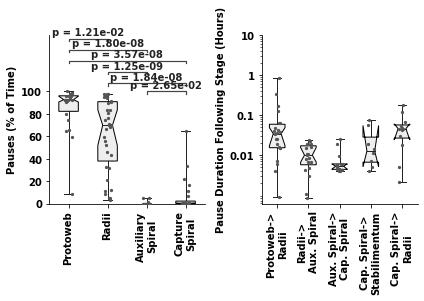

In [147]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4))

# ==========================================================================================
# Non-Gap pauses
# ==========================================================================================

ax = axs[0]
d = tblPauses[(tblPauses.stage != 'stabilimentum')&(~pd.isnull(tblPauses.pauses))]
#d = tblPauses[(tblPauses.stage != 'stabilimentum')&(tblPauses.pauses != 0)&(~pd.isnull(tblPauses.pauses))]

pairs = list(itertools.combinations(STAGES, 2))
pvals = [mannwhitneyu(x=d.pauses[d.stage==p[0]], 
                      y=d.pauses[d.stage==p[1]]).pvalue for p in pairs]
pvals = multipletests(pvals, alpha=0.05, method='bonferroni')[1]
pairsSignificant = [(p, pv) for p, pv in zip(pairs, pvals) if pv < 0.05]

for istage, stage in enumerate(STAGES):
    y = d.pauses[d.stage==stage]
    x0 = np.ones(y.size) * istage + (-0.5 + np.random.random(size=y.size)) * .2
    ax.scatter(x0, y, color='#555555', s=5, zorder=20)
    bp = ax.boxplot(y, positions=(istage,), whis=(0,100), widths=0.5,
               notch=True, bootstrap=10000, zorder=10, patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
ax.set_xticklabels([{
    'protoweb': 'Protoweb',
    'radii': 'Radii',
    'spiral_aux': 'Auxiliary\nSpiral',
    'spiral_cap': 'Capture\nSpiral'
}[x] for x in STAGES], rotation=90)
    
[ax.spines[x].set_visible(False) for x in ['top', 'right']]

ax.set_ylabel('Pauses (% of Time)')

ax.set_ylim(0, 150)
ax.set_yticks([0, 20, 40, 60, 80, 100])

lvls = {
    ('protoweb', 'radii'): 147,
    ('protoweb', 'spiral_aux'): 137,
    ('protoweb', 'spiral_cap'): 127,
    ('radii', 'spiral_aux'): 117,
    ('radii', 'spiral_cap'): 107,
    ('spiral_aux', 'spiral_cap'): 100
}
for p, pv in pairsSignificant:
    i0 = STAGES.index(p[0])
    i1 = STAGES.index(p[1])
    lvl = lvls[p]
    ax.plot([i0, i0, i1, i1], [lvl-2, lvl, lvl, lvl-2], 
            color='#444444', linewidth=1.2)
    ax.text((i0 + i1) * 0.5, lvl * 1.01, 
        'p = {:.2e}'.format(pv), ha='center', va='bottom', color='#222222')
    
# ==========================================================================================
# Gap pauses
# ==========================================================================================

ax = axs[1]
d = tblPausesWithGaps[(tblPausesWithGaps.stage != 'stabilimentum')&(tblPausesWithGaps.pauses != 0)&(~pd.isnull(tblPausesWithGaps.pauses))]

stagesGaps = tblPausesWithGaps.stage.unique()
for istage, stage in enumerate(stagesGaps):
    y = d.pauses[d.stage==stage]
    x0 = np.ones(y.size) * istage + (-0.5 + np.random.random(size=y.size)) * .2
    ax.scatter(x0, y, color='#555555', s=5, zorder=20)
    bp = ax.boxplot(y, positions=(istage,), whis=(0,100), widths=0.5,
               notch=True, bootstrap=10000, zorder=10, patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
ax.set_xticklabels([{
    'protoweb-radii': 'Protoweb->\nRadii',
    'radii-spiral_aux': 'Radii->\nAux. Spiral',
    'spiral_aux-spiral_cap': 'Aux. Spiral->\nCap. Spiral',
    'spiral_cap-stabilimentum': 'Cap. Spiral->\nStabilimentum',
    'spiral_cap-radii': 'Cap. Spiral->\nRadii'
}[x] for x in stagesGaps], rotation=90)

ax.set_yscale('log')
    
[ax.spines[x].set_visible(False) for x in ['top', 'right']]


#ax.set_yticklabels(['10 seconds', '1 minute', '10 minutes', '1 hour', '10 hours'])
#ax.set_yticks([10/3600.0, 1/60.0, 1/6.0, 1, 10])
#ax.set_ylabel('Pause Duration Following Stage')

ax.set_yticklabels(['0.01', '0.1', '1', '10'])
ax.set_yticks([0.01, 0.1, 1, 10])
ax.set_ylabel('Pause Duration Following Stage (Hours)')

fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_3e-pt2_withavis.pdf')